In [1]:
import agate

In [2]:
tester = agate.TypeTester(force={'CSD_ID' : agate.Text()}, limit=10)
wells = agate.Table.from_csv('welllevels2.csv', column_types = tester)

In [3]:
print(wells)

|---------------+---------------|
|  column_names | column_types  |
|---------------+---------------|
|  CSD_ID       | Text          |
|  County       | Text          |
|  NRD          | Text          |
|  SurfWatBasin | Text          |
|  LatDD        | Number        |
|  LongDD       | Number        |
|  YearMsr      | Number        |
|  DateMsr      | Date          |
|  Date         | Date          |
|  Season       | Text          |
|  WatLevel     | Number        |
|---------------+---------------|



In [4]:
well_years = wells.where(lambda row: row['YearMsr'] != None)
well_years = well_years.where(lambda row: row['WatLevel'] != None)
print(len(well_years.rows))

733750


In [5]:
each_well = well_years.group_by('CSD_ID')

In [7]:
smells = each_well.aggregate([
    ('count', agate.Count()),
    ('min_level', agate.Min('WatLevel')),
    ('max_level', agate.Max('WatLevel')),
])

In [8]:
oldwells = smells.where(lambda row: row['count'] > 200)

In [9]:
each_well = each_well.group_by('Season')

In [10]:
each_well = each_well.group_by('County')

In [11]:
year_groups = each_well.group_by(
    lambda r: '%i' % (r['YearMsr'] // 10),
    key_name='year_group'
)

In [12]:
means = year_groups.aggregate([
    ('count', agate.Count()),
    ('average_level', agate.Mean('WatLevel')),
])

In [13]:
print(means)

|----------------+---------------|
|  column_names  | column_types  |
|----------------+---------------|
|  CSD_ID        | Text          |
|  Season        | Text          |
|  County        | Text          |
|  year_group    | Text          |
|  count         | Number        |
|  average_level | Number        |
|----------------+---------------|



In [14]:
means.print_table(max_rows=50)

|------------------+--------+---------+------------+-------+-----------------------|
|  CSD_ID          | Season | County  | year_group | count |        average_level  |
|------------------+--------+---------+------------+-------+-----------------------|
|  423157000000000 | Winter | DAWES   | 193        |     1 | 100.0000000000000...  |
|  423157000000000 | Winter | DAWES   | 200        |     1 | 48.15000000000000...  |
|  423157000000000 | Spring | DAWES   | 197        |     3 | 47.38000000000000...  |
|  423157000000000 | Spring | DAWES   | 198        |     7 | 48.29428571428571...  |
|  423157000000000 | Spring | DAWES   | 199        |     9 | 50.95111111111111...  |
|  423157000000000 | Spring | DAWES   | 200        |    10 | 51.10800000000000...  |
|  423157000000000 | Spring | DAWES   | 201        |     5 | 52.40000000000000...  |
|  423157000000000 | Fall   | DAWES   | 198        |     8 | 49.91375000000000...  |
|  423157000000000 | Fall   | DAWES   | 199        |     7 | 50.3

In [15]:
springs = means.where(lambda row: row['Season'] == 'Spring').order_by('year_group', reverse=True)

In [16]:
falls = means.where(lambda row: row['Season'] == 'Fall').order_by('year_group', reverse=True)

In [17]:
springs.to_csv('springaverages.csv')
falls.to_csv('fallaverages.csv')

In [18]:
buffalo = means.where(lambda row: row['County'] == 'BUFFALO').order_by('year_group', reverse=True)

In [19]:
buffalo.to_csv('buffaloaverages.csv')

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
import pandas as pd
%matplotlib inline

In [21]:
df = pd.read_csv('buffaloaverages.csv')

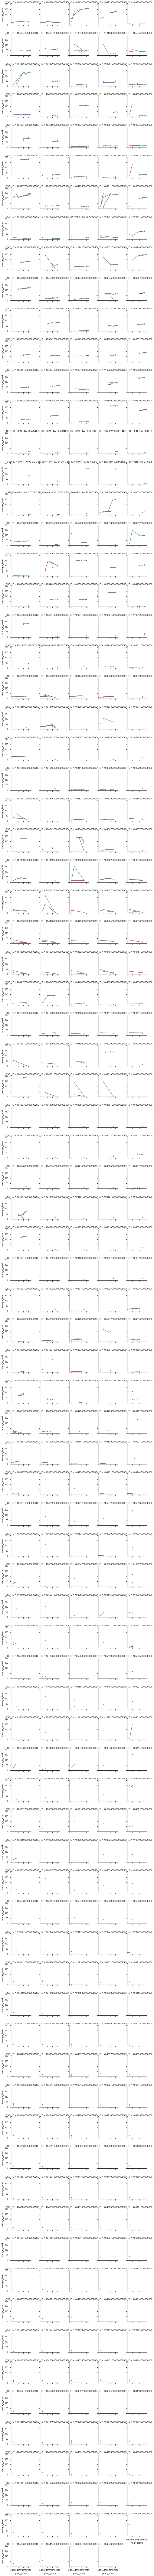

In [22]:
grid = sns.FacetGrid(df, col="CSD_ID", hue="Season", col_wrap=5, size=2)
grid.map(plt.plot, "year_group", "average_level", marker="o", ms=4)

In [23]:
pre_1970 = well_years.where(lambda row: row['YearMsr'] <= 1970)

In [24]:
print(len(pre_1970.rows))

250247


In [25]:
by_well = pre_1970.group_by('CSD_ID')

In [28]:
pre_1970_totals = by_well.aggregate([
    ('count', agate.Count())
])

In [29]:
pre_1970_totals.print_table()

|------------------+--------|
|  CSD_ID          | count  |
|------------------+--------|
|  423157000000000 |     1  |
|  413949000000000 |    41  |
|  414007000000000 |   642  |
|  404345000000000 |   560  |
|  404606000000000 |   323  |
|  404924000000000 |   301  |
|  405059000000000 |   264  |
|  404731000000000 |   269  |
|  404954000000000 |   328  |
|  404432000000000 |   492  |
|  400040000000000 |   312  |
|  401315000000000 |    55  |
|  404151000000000 |   690  |
|  404219000000000 |   378  |
|  404248000000000 |   495  |
|  404311000000000 |   403  |
|  404324000000000 |   394  |
|  404350000000000 |   449  |
|  404403000000000 |   493  |
|  403848000000000 |   221  |
|  403855000000000 | 1,020  |
|  404236000000000 |   241  |
|  404612000000000 |   177  |
|  403936000000000 |   283  |
|  404244000000000 |   294  |
|  404349000000000 |   235  |
|  404446000000000 |   326  |
|  404528000000000 |   261  |
|  404619000000000 |   304  |
|  404620000000000 | 1,062  |
|  4046340

In [30]:
pre_1970_join = pre_1970_totals.join(well_years, 'CSD_ID','CSD_ID', inner=True)

In [31]:
print(len(pre_1970_join.rows))

610012


In [32]:
print(pre_1970_join)

|---------------+---------------|
|  column_names | column_types  |
|---------------+---------------|
|  CSD_ID       | Text          |
|  count        | Number        |
|  County       | Text          |
|  NRD          | Text          |
|  SurfWatBasin | Text          |
|  LatDD        | Number        |
|  LongDD       | Number        |
|  YearMsr      | Number        |
|  DateMsr      | Date          |
|  Date         | Date          |
|  Season       | Text          |
|  WatLevel     | Number        |
|---------------+---------------|



In [35]:
to_transpose = pre_1970_join.select(['CSD_ID','YearMsr', 'WatLevel'])

In [59]:
to_transpose.to_csv('to_transpose.csv')

In [43]:
print(to_transpose)

|---------------+---------------|
|  column_names | column_types  |
|---------------+---------------|
|  CSD_ID       | Text          |
|  YearMsr      | Number        |
|  WatLevel     | Number        |
|---------------+---------------|



In [53]:
to_transpose = to_transpose.order_by('YearMsr')

In [54]:
transposed = to_transpose.denormalize(key='CSD_ID', value_column='WatLevel', property_column='YearMsr', default_value=None)

In [55]:
print(transposed)

|---------------+---------------|
|  column_names | column_types  |
|---------------+---------------|
|  CSD_ID       | Text          |
|  0.7          | Number        |
|  1885         | Number        |
|  1900         | Number        |
|  1905         | Number        |
|  1908         | Number        |
|  1910         | Number        |
|  1912         | Number        |
|  1914         | Number        |
|  1921         | Number        |
|  1924         | Number        |
|  1925         | Number        |
|  1928         | Number        |
|  1929         | Number        |
|  1930         | Number        |
|  1931         | Number        |
|  1932         | Number        |
|  1933         | Number        |
|  1934         | Number        |
|  1935         | Number        |
|  1936         | Number        |
|  1937         | Number        |
|  1938         | Number        |
|  1939         | Number        |
|  1940         | Number        |
|  1941         | Number        |
|  1942       

In [56]:
transposed.print_table(max_rows = 10)

|------------------+------+------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+------+------+------+------+------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+---------|
|  CSD_ID          |  0.7 | 1885 |  1900 | 1905 | 1908 | 1910 | 1912 | 1914 | 1921 | 1924 | 1925 | 1928 | 1929 | 1930 | 1931 | 1932 | 1933 | 1934 | 1935 | 1936 | 1937 | 1938 | 1939 | 1940 | 1941 | 1942 |

In [57]:
transposed.to_csv('transposed.csv')

In [67]:
df2 = pd.read_csv('to_transpose.csv', nrows=10)

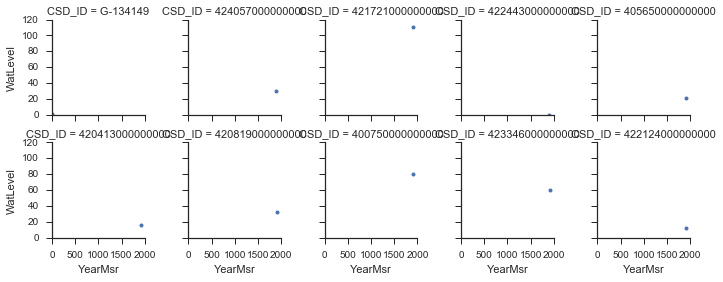

In [68]:
grid = sns.FacetGrid(df2, col="CSD_ID", col_wrap=5, size=2)
grid.map(plt.plot, "YearMsr", "WatLevel", marker="o", ms=4)